['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


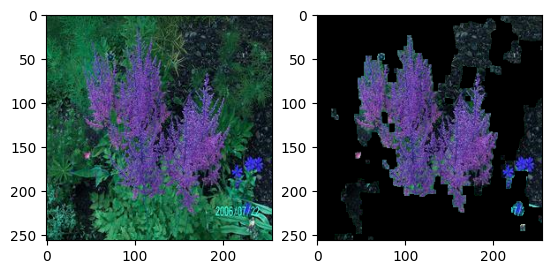

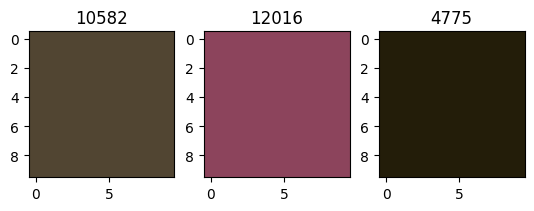

In [1]:
# we will need to manually add labels for color, since all we have right now is species.
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans


def extract_flower_color(image_path):
    # read in image
    img_bgr = cv2.imread(image_path)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)  # convert to hsv

    # remove greens
    lower = np.array([35, 40, 40])  # remove green hues, between 35 and 85, also extremely dull colors
    upper = np.array([100, 255, 255])
    mask = cv2.inRange(img_hsv, lower, upper)
    mask = cv2.bitwise_not(mask)

    # cleanup and mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    segmented = cv2.bitwise_and(img_bgr,img_bgr,mask=mask)
    plt.subplot(1,2,1); plt.imshow(img_bgr)
    plt.subplot(1,2,2); plt.imshow(segmented)
    plt.show()

    # convert to LAB - better for distinguishing color similarities
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

    # extract pixels and flatten
    pixels = np.where(mask > 0)
    pixels_lab = img_hsv[pixels[0], pixels[1], :]
    #print(pixels_lab.shape)

    # apply kmeans
    kmeans = KMeans(n_clusters = k, random_state=25).fit(pixels_lab)
    labels, centers = kmeans.labels_, kmeans.cluster_centers_
    #print(labels, centers)

    # count how many pixels were clustered into each group
    counts = np.bincount(labels)
    #print(counts)

    # grab cenrtoids and counts
    centroids = []
    for cluster_index, count in enumerate(counts):
        centroids.append((centers[cluster_index], int(count)))

    for i in range(k):
        color = centroids[i][0]
        frequency = centroids[i][1]
        #print(frequency)
        color = np.uint8([[color]])
        rgb = cv2.cvtColor(color, cv2.COLOR_HSV2RGB)
        #print(rgb)
        box = np.zeros((10,10,3), dtype=np.uint8)
        box[:,:] = rgb

        plt.subplot(1,k,i+1); plt.imshow(box); plt.title(frequency)
        
    plt.show()

    return img_bgr, img_lab, centroids

k = 3

species = 'dandelion/'
image_paths = os.listdir(f'flowers')
print(image_paths)

for i in range(len(image_paths)):
    species = image_paths[i]
    species_list = os.listdir('flowers/' + species)
    for j in range(2):
        img_bgr, lab, centroids = extract_flower_color('flowers/' + species + '/'+species_list[j+3])
        #print(lab)
        break
    break


['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']



0: 640x640 10 Acauliss, 2 Dandelions, 1 bearded_iris, 71.8ms
Speed: 2.2ms preprocess, 71.8ms inference, 31.7ms postprocess per image at shape (1, 3, 640, 640)


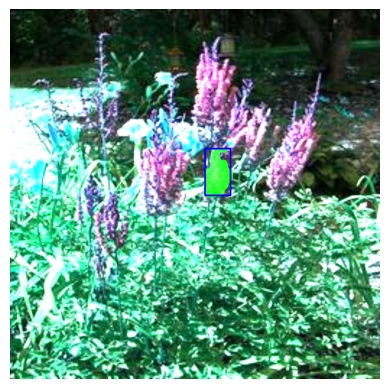

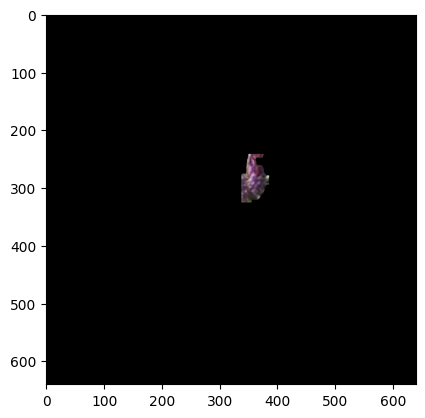

astilbe_1052587144_34c9f0714c_c
masks/astilbe_1052587144_34c9f0714c_c.pt
astilbe


In [ ]:
## Eventually - cut off confidence threshold to handle pictures that don't have a flower

from ultralytics import YOLO
import torch
import csv

def initialize_segmentation_model(path):
    model = YOLO(path)
    model.eval()
    return model

def segment_flower(image_path, model, name):
    img_bgr = cv2.imread(image_path)
    # convert bgr to rgb, rescale, resize to match model expectation
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.astype('float32') / 255.0
    img_rgb = cv2.resize(img_rgb, (640,640))
    img_tensor = torch.from_numpy(img_rgb).permute((2,0,1)).unsqueeze(0)
    #print(img_tensor.shape)
    #print(img_rgb.min(), img_rgb.max(), img_rgb.dtype)

    # predict result
    results = model.predict(img_tensor, conf=0.05, save=False, show=True)
    r = results[0]

    # if we don't find any boxes - we want to be able to flag it and return some kind of error
    error = False
    if len(r.boxes) == 0:
        print("No flowers here, fam")
        error = True
        return None, None

    # identify highest scoring mask
    scores = r.boxes.conf.cpu().numpy()
    idx_max = scores.argmax()
    annotated = r.orig_img.copy()

    # if we have a mask, we want to color it in on the original image
    if r.masks is not None:
        best_mask = r.masks.data[idx_max].cpu().numpy()  # (H, W)
        best_mask = cv2.resize(best_mask, (annotated.shape[1], annotated.shape[0]))  # match original image

        binary_mask = (best_mask > 0.5).astype(np.uint8)
        overlay = annotated.copy()
        overlay[binary_mask== 1] = (0,255,0)

        # Blend with original image
        annotated = cv2.addWeighted(annotated, 0.7, overlay, 1.0, 0)

        # also draw bounding box, why not
        box = r.boxes.xyxy[idx_max].cpu().numpy().astype(int)
        cv2.rectangle(annotated, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    else:
        print("No masks found for this detection.")
        annotated = r.plot()

    #print(annotated.shape)
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    plt.imshow(annotated_rgb)
    plt.axis("off")
    plt.show()

    binary_mask = np.stack([binary_mask]*3, axis=-1)
    flower = img_rgb * binary_mask
    #print(flower.shape)
    plt.imshow(flower)
    plt.show()

    mask_path = f'masks/{name}.pt'

    return flower, binary_mask, mask_path, error


def dominant_color(k, flower, mask):
    # Ensure mask is single-channel
    if mask.ndim == 3:
        mask_gray = mask[..., 0]
    else:
        mask_gray = mask

    # convert to LAB - better for distinguishing color similarities
    flower_uint8 = (flower * 255).astype(np.uint8)
    flower_lab = cv2.cvtColor(flower_uint8, cv2.COLOR_RGB2LAB)


    # extract pixels and print error if none are present
    pixels = flower_lab[mask_gray > 0]
    if len(pixels) == 0:
        print("No valid pixels found in mask.")
        return None

    # apply kmeans
    kmeans = KMeans(n_clusters=k, random_state=25).fit(pixels)
    labels, centers = kmeans.labels_, kmeans.cluster_centers_

    # count how many pixels were clustered into each group
    counts = np.bincount(labels)
    dominant_idx = np.argmax(counts)
    dominant_lab = centers[dominant_idx]
    return dominant_lab

    '''sorted_idx = np.argsort(-counts)

    # Sort by frequency (descending)
    centers = centers[sorted_idx]
    counts = counts[sorted_idx]

    # back to RGB for visualization
    rgb_centers = cv2.cvtColor(np.uint8(centers[np.newaxis, :, :]), cv2.COLOR_LAB2RGB)[0]

    # Display colors and frequencies
    plt.figure(figsize=(8, 2))
    for i, (color, freq) in enumerate(zip(rgb_centers, counts)):
        patch = np.ones((50, 50, 3), dtype=np.uint8) * color
        plt.subplot(1, k, i+1)
        plt.imshow(patch)
        plt.title(f"{freq}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Return sorted color centers and their frequencies
    return rgb_centers, counts

    # grab cenrtoids and counts
    centroids = []
    for cluster_index, count in enumerate(counts):
        centroids.append((centers[cluster_index], int(count)))

    for i in range(k):
        color = centroids[i][0]
        frequency = centroids[i][1]
        #print(frequency)
        color = np.uint8([[color]])
        rgb = cv2.cvtColor(color, cv2.COLOR_HSV2RGB)
        #print(rgb)
        box = np.zeros((10,10,3), dtype=np.uint8)
        box[:,:] = rgb

        plt.subplot(1,k,i+1); plt.imshow(box); plt.title(frequency)
        
    plt.show()'''



model = initialize_segmentation_model("flowers_segmentation_model.pt")

image_paths = os.listdir(f'flowers')
print(image_paths)

# create csv to save image paths and data
images = open('images.csv', mode='w', newline='')
csv_writer = csv.writer(images)
csv_writer.writerow(['Path', 'Mask Path', 'Species', 'Color'])

# create csv to save issue images
empty_images = open('empty_images.csv', mode='w', newline='')
csv_writer_err = csv.writer(empty_images)
csv_writer_err.writerow(['Path', 'Mask Path', 'Species', 'Color'])

k = 3


for i in range(len(image_paths)):
    species = image_paths[i]
    species_list = os.listdir('flowers/' + species)
    for j in range(1):
        image_path = 'flowers/' + species + '/' + species_list[j+6]
        image_name = f'{species}_{species_list[j+6]}'
        image_name = image_name[:-4]

        flower, binary_mask, mask_path, error = segment_flower(image_path, model, image_name)

        print(image_name)
        print(mask_path)
        print(species)

        dominant_lab = dominant_color(k, flower, binary_mask)

        if error == False:
            csv_writer.writerow([image_path, mask_path, species, dominant_lab])
        else:
            csv_writer_err.writerow([image_path, mask_path, species, dominant_lab])
        break
    break

images.close()
empty_images.close()

    


torch.Size([1, 3, 640, 640])
0.0 0.9868628 float32



0: 640x640 2 Acauliss, 1 Dandelion, 1 cape_flower, 1 lotus, 63.7ms
Speed: 10.4ms preprocess, 63.7ms inference, 14.4ms postprocess per image at shape (1, 3, 640, 640)
(640, 640, 3)
tensor([[564.3887, 402.8228, 614.1692, 446.7935],
        [380.4445, 494.3373, 423.2873, 555.6239],
        [368.6604, 159.7901, 509.0317, 495.8145],
        [440.5604, 168.6926, 475.3177, 304.4753],
        [ 94.7744,  37.2654, 530.6627, 581.1869]], device='cuda:0')
ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
       

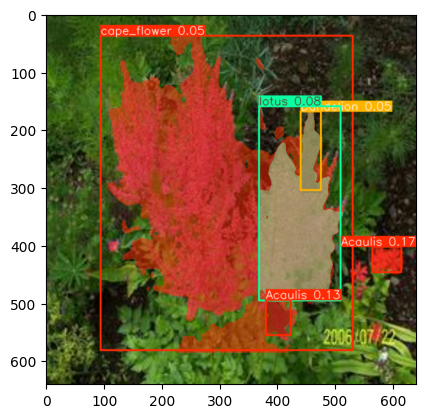

In [ ]:


#pre_seg = torch.load('flowers_segmentation_model.pt')
#print(pre_seg)

model = YOLO("flowers_segmentation_model.pt")
#model = YOLO("yolov8n-seg.pt")
#print(model)
  # set to evaluation mode

#model.load_state_dict(pre_seg)


0.0 1.0 float32



0: 256x256 (no detections), 22.6ms
Speed: 0.7ms preprocess, 22.6ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 256)
Results saved to C:\Users\eocon\Desktop\group_project_CS6422\model_training\data\runs\segment\predict8
(256, 256, 3)
tensor([], device='cuda:0', size=(0, 4))
None


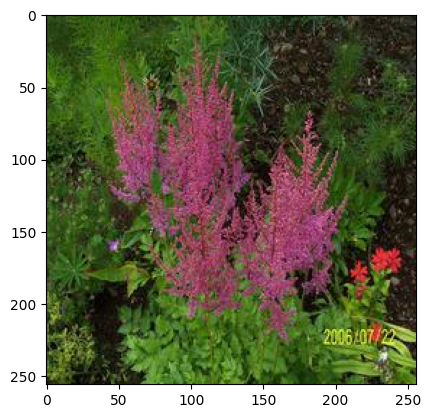

In [ ]:

#cv2.imshow("YOLOv8 Segmentation", annotated)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
# function to cluster the top 3-5 colors in the image
def cluster_colors(img, mask, k):
    # convert to LAB - better for distinguishing color similarities
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # extract pixels and flatten
    pixels = np.where(mask > 0)
    pixels_lab = img_lab[pixels[0], pixels[1], :]
    print(pixels_lab.shape)

    # apply kmeans
    kmeans = KMeans(n_clusters = k, random_state=25).fit(pixels_lab)
    labels, centers = kmeans.labels_, kmeans.cluster_centers_
    print(labels, centers)

    # count how many pixels were clustered into each group
    counts = np.bincount(labels)
    print(counts)

    # grab cenrtoids and counts
    centroids = []
    for cluster_index, count in enumerate(counts):
        centroids.append((centers[cluster_index], int(count)))

    return img_lab, centroids

k = 3
lab, centroids = cluster_colors(extracted_img, mask, k)
print(centroids)

(158434, 3)
[0 0 0 ... 0 0 0] [[  1.85724428 128.18329116 128.653548  ]
 [106.18932007 154.73588116 133.6864734 ]
 [ 49.22992874 131.14311164 138.06342043]]
[87511 45756 25167]
[(array([  1.85724428, 128.18329116, 128.653548  ]), 87511), (array([106.18932007, 154.73588116, 133.6864734 ]), 45756), (array([ 49.22992874, 131.14311164, 138.06342043]), 25167)]


87511


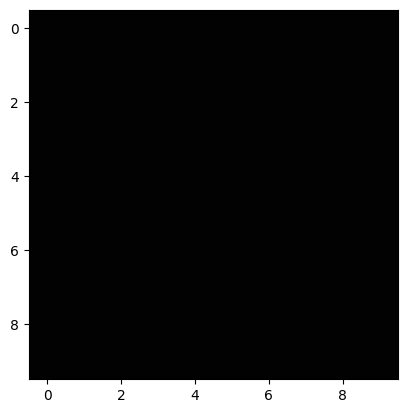

45756


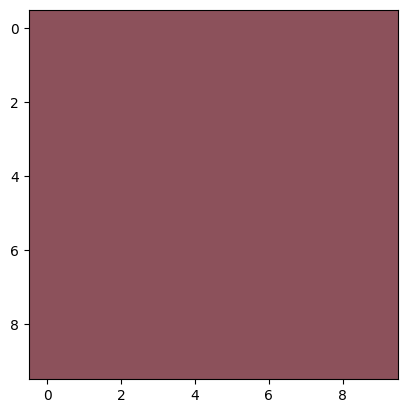

25167


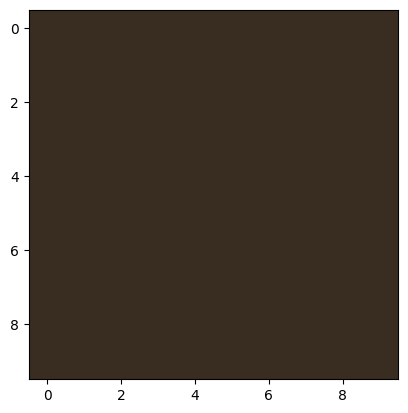

In [ ]:
for i in range(k):
    color = centroids[i][0]
    frequency = centroids[i][1]
    print(frequency)
    color = np.uint8([[color]])
    rgb = cv2.cvtColor(color, cv2.COLOR_LAB2RGB)
    #print(rgb)

    box = np.zeros((10,10,3), dtype=np.uint8)
    box[:,:] = rgb

    plt.imshow(box)
    plt.show()